<a href="https://www.kaggle.com/code/prashanthacsq/cxr-d121-na384-5fcv-0-5?scriptVersionId=108423044" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

##### Library Imports

In [1]:
import os
import re
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, classification_report, confusion_matrix

### **Utilities**

In [2]:
SEED: int = 42
SIZE: int = 384

def breaker(num: int=50, char: str="*") -> None:
    print("\n" + num*char + "\n")


def show_loss_graphs(L: list) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(TL) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="Train")
    plt.plot(x_Axis, VL, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Loss Graph")
    plt.show()

    
def show_accuracy_graphs(A: list) -> None:
    TA, VA = [], []
    for i in range(len(A)):
        TA.append(A[i]["train"])
        VA.append(A[i]["valid"])
    x_Axis = np.arange(1, len(TA) + 1)
    plt.figure()
    plt.plot(x_Axis, TA, "r", label="Train")
    plt.plot(x_Axis, VA, "b", label="Valid")
    plt.legend()
    plt.grid()
    plt.title("Accuracy Graph")
    plt.show()

    
def show_lr_graph(LR: list) -> None:
    x_Axis = [i+1 for i in range(len(LR))]
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, LR, "rx")
    plt.grid()
    plt.show()

    
def get_scores(y_true: np.ndarray, y_pred: np.ndarray) -> tuple:
    accuracy = accuracy_score(y_pred, y_true)
    try:
        auc = roc_auc_score(y_pred, y_true)
    except:
        auc = 0
    precision, recall, f_score, _ = precision_recall_fscore_support(y_pred, y_true)

    return accuracy, auc, precision, recall, f_score


def print_scores(accuracy: float, auc: float, precision: np.ndarray, recall: np.ndarray, f_score: np.ndarray) -> None:
    print(f"Accuracy  : {accuracy:.5f}")
    print(f"ROC-AUC   : {auc:.5f}")
    print(f"Precision : {precision}")
    print(f"Recall    : {recall}")
    print(f"F-Score   : {f_score}")

### **Configuration**

In [3]:
class CFG(object):
    def __init__(
        self, 
        seed: int = 42,
        size: int = 224,
        n_splits: int = 5,
        batch_size: int = 16,
        epochs: int = 25,
        early_stopping: int = 5,
        lr: float = 1e-4,
        wd: float = 0.0,
        max_lr: float = 1e-3,
        pct_start: float = 0.2,
        steps_per_epoch: int = 100,
        div_factor: int = 1e3, 
        final_div_factor: float = 1e3,
    ):
        
        self.seed = seed
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.epochs = epochs
        self.early_stopping = early_stopping
        self.lr = lr
        self.wd = wd
        self.max_lr = max_lr
        self.pct_start = pct_start
        self.steps_per_epoch = steps_per_epoch
        self.div_factor = div_factor
        self.final_div_factor = final_div_factor
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5],
                                                     [0.5, 0.5, 0.5]),
                                ])
        self.save_path = "saves"
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
    
cfg = CFG(
    seed=SEED,
    size=SIZE,
)

### **Dataset Template**

In [4]:
class DS(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray = None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.transform(self.images[idx]), torch.FloatTensor(self.labels[idx])
        else:
            return self.transform(self.images[idx])

### **Model**

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.model = models.densenet121(pretrained=True, progress=True)
        self.model.classifier = nn.Linear(in_features=self.model.classifier.in_features, out_features=1)

    def forward(self, x):
        return self.model(x)

### Fit and Predict Helper

In [6]:
def fit(
    model=None,
    optimizer=None, 
    scheduler_rlrop=None,
    scheduler_oclr=None,
    epochs=None, 
    early_stopping_patience=None, 
    dataloaders=None, 
    fold=None, 
    save_path=None,
    device=None,
    verbose=False
) -> tuple:
    
    def get_accuracy(y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        
        y_pred[y_pred > 0.5] = 1
        y_pred[y_pred <= 0.5] = 0
        
        return torch.count_nonzero(y_pred == y_true).item() / len(y_pred)
    
    if verbose:
        breaker()
        if fold: print(f"Training Fold {fold}...")
        else: print("Training ...")
        breaker()
        
    bestLoss: dict = {"train" : np.inf, "valid" : np.inf} 
    bestAccs: dict = {"train" : 0.0, "valid" : 0.0}
        
    Losses: list = []
    Accuracies: list = [] 
    LRs: list = []
        
    if fold: 
        ble_name = f"ble_state_fold_{fold}.pt"
        bae_name = f"bae_state_fold_{fold}.pt"
    else: 
        ble_name = f"ble_state.pt"
        bae_name = f"bae_state.pt"

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss, epochAccs = {"train" : 0.0, "valid" : 0.0}, {"train" : 0.0, "valid" : 0.0}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass, accsPerPass = [], []

            for X, y in dataloaders[phase]:
                X, y = X.to(device), y.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.BCEWithLogitsLoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        if scheduler_oclr: scheduler_oclr.step()
                lossPerPass.append(loss.item())
                accsPerPass.append(get_accuracy(output, y))
            epochLoss[phase] = np.mean(np.array(lossPerPass))
            epochAccs[phase] = np.mean(np.array(accsPerPass))
        if scheduler_oclr: LRs.append(scheduler_oclr.get_last_lr())
        Losses.append(epochLoss)
        Accuracies.append(epochAccs)
        
        if scheduler_oclr:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_oclr.state_dict()}
        
        elif scheduler_rlrop:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict(),
                         "scheduler_state_dict" : scheduler_rlrop.state_dict()}
        
        else:
            save_dict = {"model_state_dict"     : model.state_dict(),
                         "optim_state_dict"     : optimizer.state_dict()}
        
        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save(save_dict, os.path.join(save_path, ble_name))
                torch.save(save_dict, os.path.join(save_path, bae_name))
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    print("\nEarly Stopping at Epoch {}".format(e + 1))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save(save_dict,os.path.join(save_path, ble_name))
        
        if epochAccs["valid"] > bestAccs["valid"]:
            bestAccs = epochAccs
            BAE = e + 1
            torch.save(save_dict,os.path.join(save_path, bae_name))
        
        if scheduler_rlrop: scheduler_rlrop.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Train Accs: {:.5f} | Valid Accs: {:.5f} | Time: {:.2f} seconds".format(e+1, 
                                                                       epochLoss["train"], epochLoss["valid"], 
                                                                       epochAccs["train"], epochAccs["valid"], 
                                                                       time()-e_st))

    if verbose:                                           
        breaker()
        print(f"Best Validation Loss at Epoch {BLE}")
        breaker()
        print(f"Best Validation Accs at Epoch {BAE}")
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
    
    return Losses, Accuracies, LRs, bestLoss, bestAccs, BLE, BAE, ble_name, bae_name


def predict(model=None, dataloader=None, path=None, device=None) -> np.ndarray:
    model.load_state_dict(torch.load(path, map_location=device)["model_state_dict"])
    model.to(device)    
    model.eval()
    
    y_pred = torch.zeros(1, 1).to(device)
    
    for X in dataloader:
        X = X.to(device)
        with torch.no_grad():
            output = torch.sigmoid(model(X))
        y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    return y_pred[1:].detach().cpu().numpy()

### **Train**

In [7]:
images = np.load(f"../input/cxr-images-{SIZE}/train_images_{SIZE}.npy")
labels = np.load(f"../input/cxr-images-{SIZE}/train_targets_{SIZE}.npy")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]


**************************************************

Training Fold 1...

**************************************************

Epoch: 1 | Train Loss: 0.33985 | Valid Loss: 0.07731 | Train Accs: 0.82191 | Valid Accs: 0.97010 | Time: 99.39 seconds
Epoch: 2 | Train Loss: 0.08962 | Valid Loss: 0.12812 | Train Accs: 0.96862 | Valid Accs: 0.95076 | Time: 90.31 seconds
Epoch: 3 | Train Loss: 0.08877 | Valid Loss: 0.06554 | Train Accs: 0.96756 | Valid Accs: 0.97863 | Time: 92.46 seconds
Epoch: 4 | Train Loss: 0.08093 | Valid Loss: 0.04546 | Train Accs: 0.96613 | Valid Accs: 0.98458 | Time: 92.17 seconds
Epoch: 5 | Train Loss: 0.06004 | Valid Loss: 0.21017 | Train Accs: 0.97638 | Valid Accs: 0.93317 | Time: 91.70 seconds
Epoch: 6 | Train Loss: 0.04376 | Valid Loss: 0.04280 | Train Accs: 0.98378 | Valid Accs: 0.98552 | Time: 91.69 seconds
Epoch: 7 | Train Loss: 0.05659 | Valid Loss: 0.27025 | Train Accs: 0.97901 | Valid Accs: 0.93182 | Time: 91.40 seconds
Epoch: 8 | Train Loss: 0.03859 | Valid Los

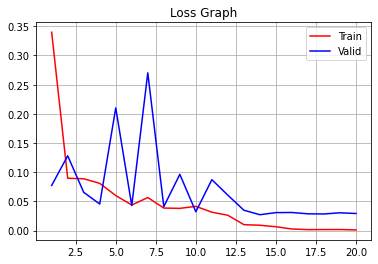


**************************************************



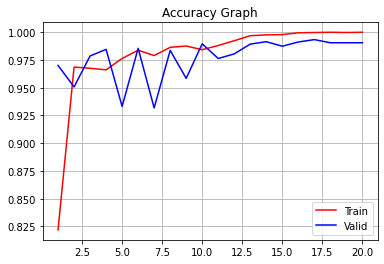


**************************************************



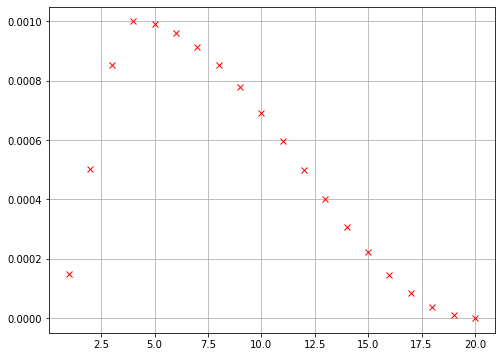


**************************************************


**************************************************

Training Fold 2...

**************************************************

Epoch: 1 | Train Loss: 0.34029 | Valid Loss: 0.15861 | Train Accs: 0.81976 | Valid Accs: 0.92911 | Time: 91.01 seconds
Epoch: 2 | Train Loss: 0.08973 | Valid Loss: 0.23308 | Train Accs: 0.96780 | Valid Accs: 0.92614 | Time: 90.25 seconds
Epoch: 3 | Train Loss: 0.09031 | Valid Loss: 0.18462 | Train Accs: 0.96475 | Valid Accs: 0.92086 | Time: 90.39 seconds
Epoch: 4 | Train Loss: 0.07197 | Valid Loss: 0.20390 | Train Accs: 0.97376 | Valid Accs: 0.91328 | Time: 90.56 seconds
Epoch: 5 | Train Loss: 0.05893 | Valid Loss: 0.04377 | Train Accs: 0.98068 | Valid Accs: 0.98390 | Time: 91.47 seconds
Epoch: 6 | Train Loss: 0.05821 | Valid Loss: 0.04764 | Train Accs: 0.97948 | Valid Accs: 0.98295 | Time: 90.72 seconds
Epoch: 7 | Train Loss: 0.04429 | Valid Loss: 0.09394 | Train Accs: 0.98593 | Valid Accs: 0.97254 | Time: 90.

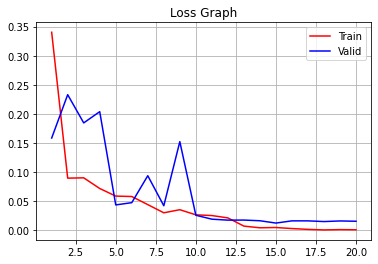


**************************************************



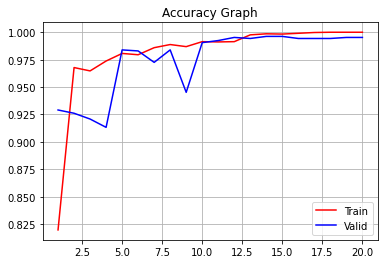


**************************************************



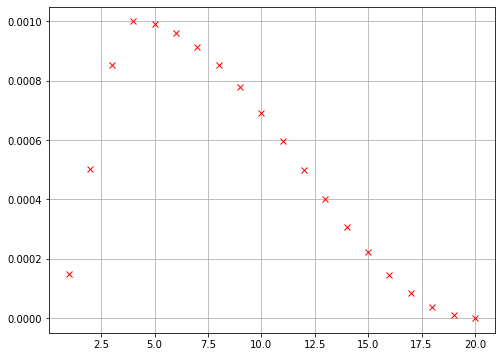


**************************************************


**************************************************

Training Fold 3...

**************************************************

Epoch: 1 | Train Loss: 0.34614 | Valid Loss: 0.08711 | Train Accs: 0.81570 | Valid Accs: 0.96970 | Time: 91.09 seconds
Epoch: 2 | Train Loss: 0.09113 | Valid Loss: 0.93777 | Train Accs: 0.97028 | Valid Accs: 0.69508 | Time: 90.60 seconds
Epoch: 3 | Train Loss: 0.08894 | Valid Loss: 0.12499 | Train Accs: 0.96336 | Valid Accs: 0.96244 | Time: 90.67 seconds
Epoch: 4 | Train Loss: 0.09235 | Valid Loss: 0.09091 | Train Accs: 0.96336 | Valid Accs: 0.96686 | Time: 90.18 seconds
Epoch: 5 | Train Loss: 0.07501 | Valid Loss: 0.34493 | Train Accs: 0.97328 | Valid Accs: 0.85701 | Time: 90.42 seconds
Epoch: 6 | Train Loss: 0.05805 | Valid Loss: 0.03471 | Train Accs: 0.97853 | Valid Accs: 0.99053 | Time: 91.23 seconds
Epoch: 7 | Train Loss: 0.04472 | Valid Loss: 0.14041 | Train Accs: 0.98593 | Valid Accs: 0.95013 | Time: 89.

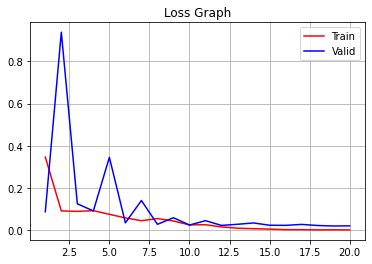


**************************************************



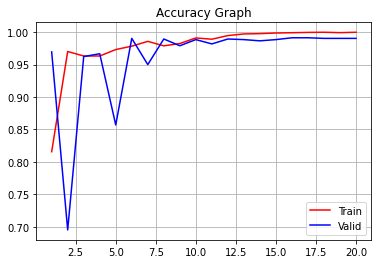


**************************************************



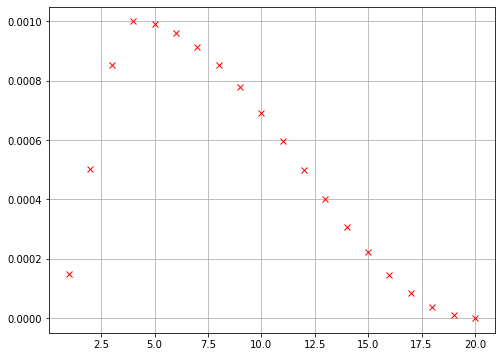


**************************************************


**************************************************

Training Fold 4...

**************************************************

Epoch: 1 | Train Loss: 0.34070 | Valid Loss: 0.07672 | Train Accs: 0.81436 | Valid Accs: 0.97033 | Time: 90.92 seconds
Epoch: 2 | Train Loss: 0.09792 | Valid Loss: 0.07731 | Train Accs: 0.96336 | Valid Accs: 0.98106 | Time: 90.54 seconds
Epoch: 3 | Train Loss: 0.10884 | Valid Loss: 0.07217 | Train Accs: 0.96040 | Valid Accs: 0.97664 | Time: 91.18 seconds
Epoch: 4 | Train Loss: 0.07051 | Valid Loss: 0.03357 | Train Accs: 0.97600 | Valid Accs: 0.98769 | Time: 90.82 seconds
Epoch: 5 | Train Loss: 0.06288 | Valid Loss: 0.03601 | Train Accs: 0.97805 | Valid Accs: 0.98485 | Time: 90.08 seconds
Epoch: 6 | Train Loss: 0.05050 | Valid Loss: 0.07386 | Train Accs: 0.98115 | Valid Accs: 0.96212 | Time: 90.18 seconds
Epoch: 7 | Train Loss: 0.05002 | Valid Loss: 0.06220 | Train Accs: 0.98235 | Valid Accs: 0.97443 | Time: 90.

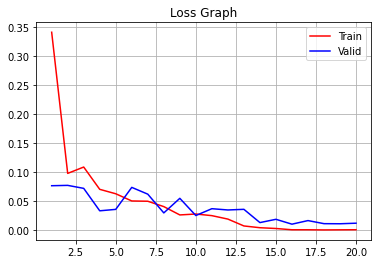


**************************************************



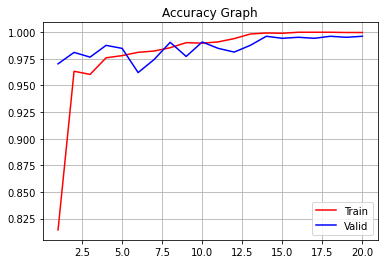


**************************************************



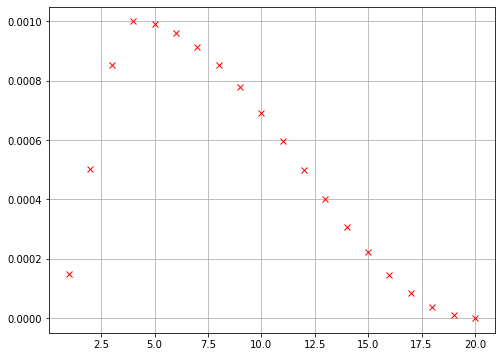


**************************************************


**************************************************

Training Fold 5...

**************************************************

Epoch: 1 | Train Loss: 0.34574 | Valid Loss: 0.13216 | Train Accs: 0.81345 | Valid Accs: 0.95076 | Time: 90.60 seconds
Epoch: 2 | Train Loss: 0.09827 | Valid Loss: 0.23890 | Train Accs: 0.96636 | Valid Accs: 0.91288 | Time: 90.28 seconds
Epoch: 3 | Train Loss: 0.07765 | Valid Loss: 0.51750 | Train Accs: 0.96851 | Valid Accs: 0.82355 | Time: 90.22 seconds
Epoch: 4 | Train Loss: 0.07294 | Valid Loss: 0.08380 | Train Accs: 0.97323 | Valid Accs: 0.96812 | Time: 90.98 seconds
Epoch: 5 | Train Loss: 0.07437 | Valid Loss: 0.12087 | Train Accs: 0.97066 | Valid Accs: 0.95170 | Time: 90.09 seconds
Epoch: 6 | Train Loss: 0.04663 | Valid Loss: 0.03627 | Train Accs: 0.98163 | Valid Accs: 0.98580 | Time: 90.92 seconds
Epoch: 7 | Train Loss: 0.05835 | Valid Loss: 0.05170 | Train Accs: 0.97758 | Valid Accs: 0.97917 | Time: 90.

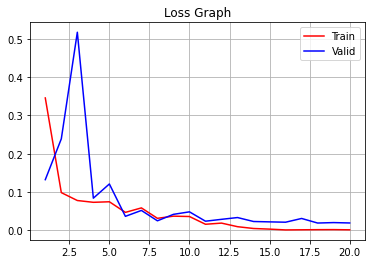


**************************************************



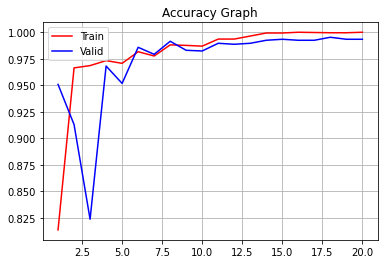


**************************************************



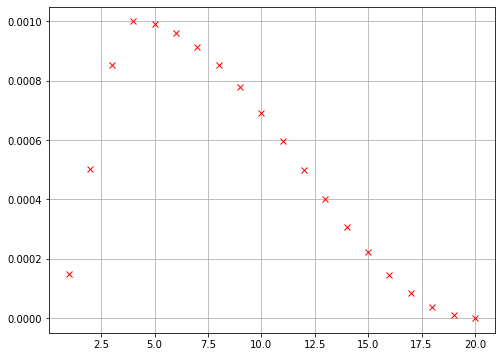


**************************************************



In [8]:
fold: int = 1
BLs: list = []
BAs: list = []
    
cfg.batch_size = 16
cfg.epochs = 20
cfg.lr = 1e-3
cfg.wd = 0.0


for tr_idx, va_idx in KFold(n_splits=cfg.n_splits, random_state=SEED, shuffle=True).split(images):
    tr_images, va_images, tr_labels, va_labels = images[tr_idx], images[va_idx], labels[tr_idx], labels[va_idx]

    tr_data_setup = DS(tr_images, tr_labels.reshape(-1, 1), cfg.transform)
    va_data_setup = DS(va_images, va_labels.reshape(-1, 1), cfg.transform)

    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=cfg.batch_size, shuffle=True, generator=torch.manual_seed(cfg.seed)),
        "valid" : DL(va_data_setup, batch_size=cfg.batch_size, shuffle=False),
    }

    cfg.steps_per_epoch=len(dataloaders["train"])

    torch.manual_seed(cfg.seed)
    model = Model().to(cfg.device)
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    # optimizer = optim.AdamW([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd)
    # optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=cfg.lr, weight_decay=cfg.wd, momentum=0.9)
    
    scheduler_oclr = optim.lr_scheduler.OneCycleLR(
        optimizer=optimizer, 
        max_lr=cfg.max_lr, 
        epochs=cfg.epochs, 
        steps_per_epoch=cfg.steps_per_epoch,
        pct_start=cfg.pct_start, 
        div_factor=cfg.div_factor, 
        final_div_factor=cfg.final_div_factor
    )

    # scheduler_rlrop = optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer=optimizer,
    #     patience=cfg.patience,
    #     eps=cfg.eps,
    #     verbose=True
    # )
    
    # scheduler_oclr = None
    scheduler_rlrop = None

    L, A, LR, BL, BA, _, _, _, _ = fit(
        model=model, 
        optimizer=optimizer, 
        scheduler_oclr=scheduler_oclr,
        scheduler_rlrop=scheduler_rlrop,
        epochs=cfg.epochs, 
        early_stopping_patience=cfg.early_stopping, 
        dataloaders=dataloaders, 
        device=cfg.device,
        save_path=cfg.save_path,
        fold=fold,
        verbose=True
    )
    
    breaker()
    show_loss_graphs(L)
    breaker()
    show_accuracy_graphs(A)
    breaker()
    if scheduler_oclr:
        show_lr_graph(LR)
        breaker()
    
    BLs.append(BL)
    BAs.append(BA)
    
    fold += 1

### **Best Model**

In [9]:
BL = np.inf
for i in range(len(BLs)):
    if BLs[i]["valid"] < BL:
        BL = BLs[i]["valid"]
        best_loss_index = i

        
BA = 0.0
for i in range(len(BAs)):
    if BAs[i]["valid"] > BA:
        BA = BAs[i]["valid"]
        best_accs_index = i

breaker()
print(f"Best Loss Model Fold     : {best_loss_index + 1}")
print(f"Best Accuracy Model Fold : {best_accs_index + 1}")
breaker()


**************************************************

Best Loss Model Fold     : 4
Best Accuracy Model Fold : 2

**************************************************



### **Predictions**

In [10]:
test_images = np.load(f"../input/cxr-images-{SIZE}/test_images_{SIZE}.npy")
test_labels = np.load(f"../input/cxr-images-{SIZE}/test_targets_{SIZE}.npy")

ts_data_setup = DS(test_images, None, cfg.transform)
ts_data = DL(ts_data_setup, batch_size=cfg.batch_size, shuffle=False)

model_path = f"saves/ble_state_fold_{best_loss_index + 1}.pt"
y_pred = predict(model=Model().to(cfg.device), dataloader=ts_data, path=model_path, device=cfg.device)

accuracy, auc, precision, recall, f_score = get_scores(test_labels, y_pred)

breaker()
print(f"Best Fold : {best_loss_index + 1}")
breaker()
print_scores(accuracy, auc, precision, recall, f_score)
breaker()
print(classification_report(test_labels, y_pred))
breaker()
print(confusion_matrix(test_labels, y_pred))
breaker()


**************************************************

Best Fold : 4

**************************************************

Accuracy  : 0.74038
ROC-AUC   : 0.85326
Precision : [0.30769231 1.        ]
Recall    : [1.         0.70652174]
F-Score   : [0.47058824 0.82802548]

**************************************************

              precision    recall  f1-score   support

         0.0       1.00      0.31      0.47       234
         1.0       0.71      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.65       624
weighted avg       0.82      0.74      0.69       624


**************************************************

[[ 72 162]
 [  0 390]]

**************************************************

